In [50]:
import pandas as pd
from fastai.collab import CollabDataBunch, collab_learner, load_learner, DatasetType, Path

In [51]:
user,item,title = 'userId','movieId','title'

In [171]:
cols = ['User ID','Movie ID','Rating','Timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', delimiter='\t', 
                         header=None, names=[user,item,'rating','timestamp'])
ratings_df.sample(5)

,userId,movieId,rating,timestamp
72707,666,116,4,880313270
1457,13,121,5,882397503
98210,497,121,4,879310581
59509,281,342,1,881200789
53356,158,188,4,880134332


In [53]:
movies = pd.read_csv('ml-100k/u.item',  delimiter='|', encoding='latin-1', header=None, 
                     names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [54]:
rating_movie = ratings_df.merge(movies[[item, title]])
rating_movie = rating_movie[['userId', 'movieId', 'rating', 'title']]
rating_movie.head()

,userId,movieId,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [55]:
rows = []
user_id = 99999
movie_id = [755, 24, 96, 1013, 797, 751, 689, 685, 597, 2]
title = ["Jumanji", "Rumble in the Bronx", "Terminator 2: Judgment Day", "Anaconda", "Timecop", "Tomorrow Never Dies", "The Jackal", "Executive Decision", "Eraser", "GoldenEye"]
ratings = [4, 4, 4, 3, 4, 3, 3, 4, 3, 3]

for i in range(len(movie_id)):
  rows.append( dict( {'userId' : user_id, 'movieId' : movie_id[i], 'rating' : ratings[i], 'title': title[i]}))
user_data = pd.DataFrame(rows)
print(user_data)

userId  movieId  rating                       title
0   99999      755       4                     Jumanji
1   99999       24       4         Rumble in the Bronx
2   99999       96       4  Terminator 2: Judgment Day
3   99999     1013       3                    Anaconda
4   99999      797       4                     Timecop
5   99999      751       3         Tomorrow Never Dies
6   99999      689       3                  The Jackal
7   99999      685       4          Executive Decision
8   99999      597       3                      Eraser
9   99999        2       3                   GoldenEye


In [37]:
rating_movie = pd.concat([rating_movie, user_data], axis=0)
rating_movie.tail()

,userId,movieId,rating,title
5,99999,751,3,Tomorrow Never Dies
6,99999,689,3,The Jackal
7,99999,685,4,Executive Decision
8,99999,597,3,Eraser
9,99999,2,3,GoldenEye


In [56]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1)
data.show_batch()

userId,movieId,target
618,234,4.0
720,272,4.0
910,25,3.0
757,231,2.0
687,288,4.0


In [57]:
y_range = [0,5.5] # range of target variable
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


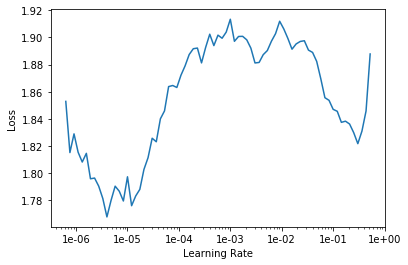

In [40]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [58]:
learn.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,time
0,0.927319,0.948671,00:05
1,0.896263,0.924020,00:05
2,0.785039,0.866666,00:05
3,0.638937,0.835517,00:06
4,0.481743,0.833539,00:05


In [42]:
(users, items), ratings = next(iter(data.valid_dl))
preds = learn.model(users, items)
print('Real\tPred\tDifference\tUser')
for p in list(zip(ratings, preds, users))[:16]:
  print('{}\t{:.1f}\t{:.1f}\t\t{}'.format(p[0],p[1],p[1]-p[0], p[2]))

Real	Pred	Difference	User
4.0	2.7	-1.3		234
5.0	4.2	-0.8		398
5.0	3.9	-1.1		97
2.0	2.7	0.7		155
5.0	3.7	-1.3		825
4.0	3.8	-0.2		504
5.0	5.0	-0.0		16
4.0	4.1	0.1		606
4.0	3.8	-0.2		22
3.0	2.6	-0.4		222
3.0	3.2	0.2		393
5.0	4.3	-0.7		398
2.0	2.9	0.9		399
2.0	2.9	0.9		363
3.0	4.0	1.0		123
3.0	3.2	0.2		846


In [43]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(945, 40)
  (i_weight): Embedding(1669, 40)
  (u_bias): Embedding(945, 1)
  (i_bias): Embedding(1669, 1)
)

In [71]:
learn.save("trained_100k_movie_model", return_path=True)

PosixPath('models/trained_100k_movie_model.pth')

In [174]:
# Logic from https://medium.com/@igorirailean/a-recommender-system-using-fastai-in-google-colab-110d363d422f
# https://github.com/IRailean/RecommenderSystem/blob/master/MovieTweetingRecommender.ipynb
rows = []
movies = list(rating_movie.drop_duplicates(subset='movieId', keep='first').movieId)
titles = list(rating_movie.drop_duplicates(subset='movieId', keep='first').title)
for i in range(len(movies)):
  rows.append( dict({'Title': titles[i], 'movieId' : movies[i], 'userId' : 99999}))
test_data = pd.DataFrame(rows)
test_data[:10]

,Title,movieId,userId
0,Kolya (1996),242,99999
1,L.A. Confidential (1997),302,99999
2,Heavyweights (1994),377,99999
3,Legends of the Fall (1994),51,99999
4,Jackie Brown (1997),346,99999
5,Dr. Strangelove or: How I Learned to Stop Worr...,474,99999
6,"Hunt for Red October, The (1990)",265,99999
7,"Jungle Book, The (1994)",465,99999
8,Grease (1978),451,99999
9,"Remains of the Day, The (1993)",86,99999


In [90]:
# Load your model
data_collab_newuser = CollabDataBunch.from_df(rating_movie, test=test_data, seed=42, valid_pct=0.1)
learn_newuser = collab_learner(data_collab_newuser, n_factors=40, y_range=(0, 5), wd=1e-2)
learner = learn_newuser.load(Path("trained_100k_movie_model"))

In [91]:
# Logic from https://medium.com/@igorirailean/a-recommender-system-using-fastai-in-google-colab-110d363d422f
# https://github.com/IRailean/RecommenderSystem/blob/master/MovieTweetingRecommender.ipynb

preds, y = learner.get_preds(DatasetType.Test)
for idx, (score, title) in enumerate(sorted(zip(preds, titles), reverse=True)):
    if idx >= 10:
        break
    print("Score: ", round(float(score), 2), " for movie: ", title)

Score:  3.42  for movie:  Schindler's List (1993)
Score:  3.4  for movie:  Shawshank Redemption, The (1994)
Score:  3.34  for movie:  Titanic (1997)
Score:  3.34  for movie:  Star Wars (1977)
Score:  3.31  for movie:  Rear Window (1954)
Score:  3.31  for movie:  Casablanca (1942)
Score:  3.28  for movie:  Good Will Hunting (1997)
Score:  3.26  for movie:  Silence of the Lambs, The (1991)
Score:  3.26  for movie:  As Good As It Gets (1997)
Score:  3.25  for movie:  Usual Suspects, The (1995)


In [152]:
# inspired by https://gilberttanner.com/blog/collaborative-filtering-with-fastai
# get top movies
g = rating_movie.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies = top_movies.astype(str)
top_movies[:10]

array(['50', '258', '100', '181', '294', '286', '288', '1', '300', '121'], dtype='<U21')

In [154]:
top_movies_with_name = []
for movie in top_movies:
    top_movies_with_name.append(rating_movie[(rating_movie['movieId']==int(movie))]['title'].iloc[0])
top_movies_with_name = np.array(top_movies_with_name)
top_movies_with_name[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype='<U79')

In [155]:
movie_bias = learn.bias(top_movies, is_item=True)

In [158]:
mean_ratings = rating_movie.groupby('movieId')['rating'].mean()
movie_ratings = [(b, top_movies_with_name[i], mean_ratings.loc[int(tb)]) for i, (tb, b) in enumerate(zip(top_movies, movie_bias))]

In [161]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:10]

[(tensor(-0.3570), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.3359), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.3074), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2992),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2918),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2912), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2790), 'Ready to Wear (Pret-A-Porter) (1994)', 1.8333333333333333),
 (tensor(-0.2781), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2768), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2700), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232)]

In [163]:
sorted(movie_ratings, key=item0, reverse=True)[:10]

[(tensor(0.7265), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.6954), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.6459), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.6400), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.6391), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.6388), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.6005), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5789), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.5527), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.5523), 'Apt Pupil (1998)', 4.1)]

In [164]:
movie_weight = learn.weight(top_movies, is_item=True)
movie_weight.shape

torch.Size([1000, 40])

In [165]:
movie_pca = movie_weight.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [168]:
fac0,fac1,fac2 = movie_pca.t()
movie_component = [(f, i) for f,i in zip(fac0, top_movies_with_name)]

In [169]:
sorted(movie_component, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2521), 'Third Man, The (1949)'),
 (tensor(1.0380), 'Hoop Dreams (1994)'),
 (tensor(1.0003),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9906), 'Thin Man, The (1934)'),
 (tensor(0.9700), 'M (1931)'),
 (tensor(0.9688), "Schindler's List (1993)"),
 (tensor(0.9548), 'Usual Suspects, The (1995)'),
 (tensor(0.9283), 'Shall We Dance? (1996)'),
 (tensor(0.9227), 'Chinatown (1974)'),
 (tensor(0.9160), 'Casablanca (1942)')]

In [170]:
# Negative Bias
sorted(movie_component, key=itemgetter(0))[:10]

[(tensor(-1.4324), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.2400), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-1.2365), 'Bio-Dome (1996)'),
 (tensor(-1.1778), 'Grease 2 (1982)'),
 (tensor(-1.1317), 'Jungle2Jungle (1997)'),
 (tensor(-1.1046), 'Leave It to Beaver (1997)'),
 (tensor(-1.0457), 'Drop Dead Fred (1991)'),
 (tensor(-1.0070), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-0.9983), 'Lawnmower Man 2: Beyond Cyberspace (1996)'),
 (tensor(-0.9932), 'D3: The Mighty Ducks (1996)')]

In [176]:
movie_component = [(f, i) for f,i in zip(fac1, top_movies_with_name)]
sorted(movie_component, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.7718), 'Three Colors: Blue (1993)'),
 (tensor(0.7061), 'Pallbearer, The (1996)'),
 (tensor(0.6966), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.6533), 'Very Brady Sequel, A (1996)'),
 (tensor(0.6438), 'Big Night (1996)'),
 (tensor(0.6406), 'Exotica (1994)'),
 (tensor(0.6057), 'Three Colors: White (1994)'),
 (tensor(0.6010), 'Spanking the Monkey (1994)'),
 (tensor(0.5925), 'Jade (1995)'),
 (tensor(0.5909), 'Brazil (1985)')]

In [178]:
# Negative Bias
sorted(movie_component, key=itemgetter(0))[:10]

[(tensor(-0.5175), 'Postman, The (1997)'),
 (tensor(-0.5128), 'Michael (1996)'),
 (tensor(-0.4884), 'Godfather, The (1972)'),
 (tensor(-0.4607), "Nobody's Fool (1994)"),
 (tensor(-0.4538), 'Cinema Paradiso (1988)'),
 (tensor(-0.4406), 'Shine (1996)'),
 (tensor(-0.4396), 'Gandhi (1982)'),
 (tensor(-0.4329), 'East of Eden (1955)'),
 (tensor(-0.4066), 'Apostle, The (1997)'),
 (tensor(-0.4023), 'Anna Karenina (1997)')]

In [180]:
movie_component = [(f, i) for f,i in zip(fac2, top_movies_with_name)]
sorted(movie_component, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.5725), 'Legends of the Fall (1994)'),
 (tensor(0.5545), 'Starship Troopers (1997)'),
 (tensor(0.5238), 'Highlander (1986)'),
 (tensor(0.4966), 'Tombstone (1993)'),
 (tensor(0.4621), 'Species (1995)'),
 (tensor(0.4441), 'Blob, The (1958)'),
 (tensor(0.4384), 'Hudsucker Proxy, The (1994)'),
 (tensor(0.4361), 'Once Upon a Time in the West (1969)'),
 (tensor(0.4273), 'Addams Family Values (1993)'),
 (tensor(0.4067), 'Basquiat (1996)')]

In [181]:
# Negative Bias
sorted(movie_component, key=itemgetter(0))[:10]

[(tensor(-0.5175), 'Postman, The (1997)'),
 (tensor(-0.5128), 'Michael (1996)'),
 (tensor(-0.4884), 'Godfather, The (1972)'),
 (tensor(-0.4607), "Nobody's Fool (1994)"),
 (tensor(-0.4538), 'Cinema Paradiso (1988)'),
 (tensor(-0.4406), 'Shine (1996)'),
 (tensor(-0.4396), 'Gandhi (1982)'),
 (tensor(-0.4329), 'East of Eden (1955)'),
 (tensor(-0.4066), 'Apostle, The (1997)'),
 (tensor(-0.4023), 'Anna Karenina (1997)')]

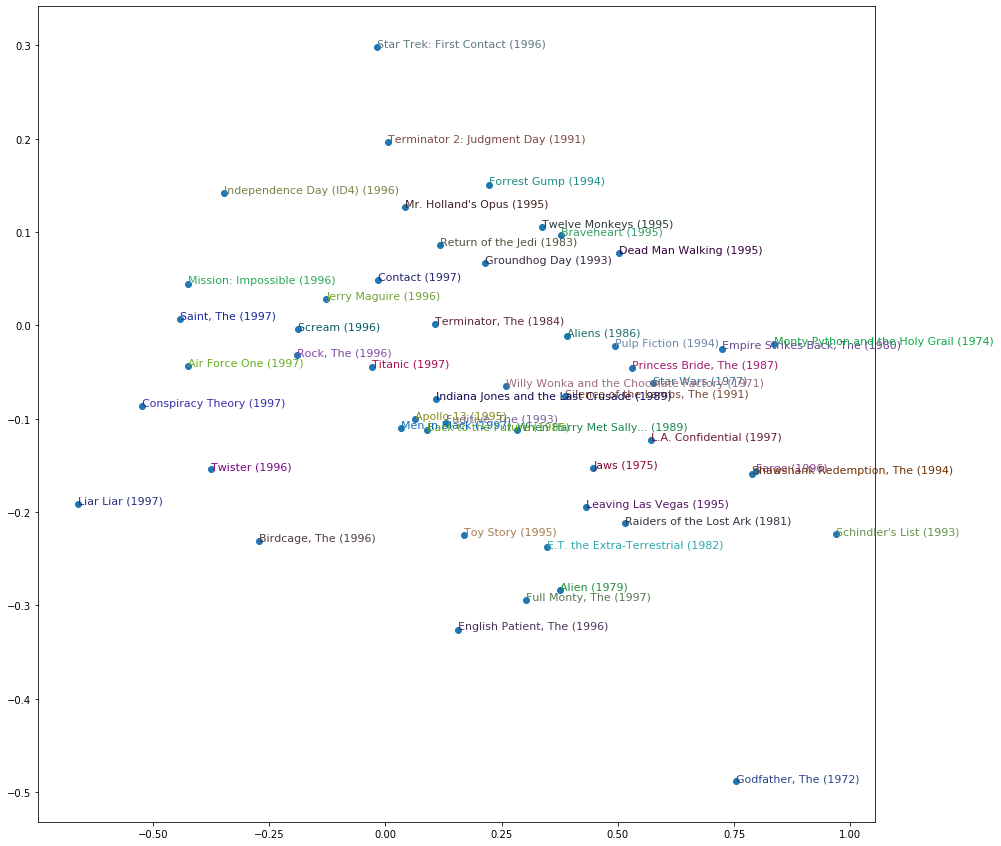

In [182]:
idxs = np.random.choice(len(top_movies_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies_with_name[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()